In [9]:
# Import Libraries
import os
import numpy as np
from utils import *
import cv2
from random import randint
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [10]:
path=os.getenv('HOME') + '/repo/Portrait/data/Celeb/data_100/'

In [11]:
# 이미지와 마스크를 load.
X = np.load(os.path.join(path,"Images.npy"))
Y = np.load(os.path.join(path,"Masks.npy"))
# 마스크를 binary format으로 변경.
Y = np.where(Y > 1, 1, 0)

In [12]:
data_info(X, Y)

이미지의 개수: 300
이미지의 모양: 512 x 512
마스크의 개수: 300
마스크의 모양: 512 x 512


<Figure size 720x720 with 0 Axes>

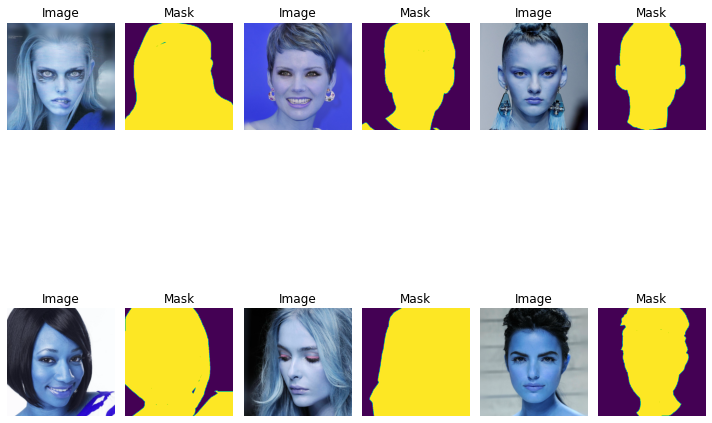

In [13]:
show_image(X, Y, 6)

In [14]:
x_train, y_train, x_valid, y_valid = train_val_split(X,Y)
del X
del Y

In [15]:
# Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator()

## Unet 구현하기

In [16]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
def unet_model(input_size=(512,512,3), filters= [16, 32, 64, 128, 256], kernel=3):
    inputs = Input(input_size)
    conv_path = []
    # normalize the images
    s = Lambda(lambda x: x / 255) (inputs)
  
    x = Conv2D(filters[0], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
    x = Conv2D(filters[0], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x)
    x = BatchNormalization()(x)
    conv_path.append(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b2_pool')(x)
    x = Conv2D(filters[1], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b2_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b2_conv2')(x)
    conv_path.append(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b3_pool')(x)
    x = Conv2D(filters[2], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b3_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b3_conv2')(x)
    conv_path.append(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b4_pool')(x)
    x = Conv2D(filters[3], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b4_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='b4_conv2')(x)
    conv_path.append(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b5_pool')(x)
    x = Conv2D(filters[4], kernel, activation='elu', padding='same',kernel_initializer='he_normal', name='b5_conv1')(x)
    
    x = UpSampling2D(size = (2,2), name='u1_up')(x)
    r1 = tf.image.resize(conv_path[3], (x.shape[1], x.shape[2]), name='u1_resize')
    x = concatenate([r1,x], axis = 3, name='u1_merge')
    x = Conv2D(filters[3], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u1_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u1_conv2')(x)
    
    x = UpSampling2D(size = (2,2), name='u2_up')(x)
    r2 = tf.image.resize(conv_path[2], (x.shape[1], x.shape[2]), name='u2_resize')
    x = concatenate([r2,x], axis = 3, name='u2_merge')
    x = Conv2D(filters[2], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u2_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u2_conv2')(x)
    
    x = UpSampling2D(size = (2,2), name='u3_up')(x)
    r3 = tf.image.resize(conv_path[1], (x.shape[1], x.shape[2]), name='u3_resize')
    x = concatenate([r3,x], axis = 3, name='u3_merge')
    x = Conv2D(filters[1], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u3_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u3_conv2')(x)
    
    x = UpSampling2D(size = (2,2), name='u4_up')(x)
    r4 = tf.image.resize(conv_path[0], (x.shape[1], x.shape[2]), name='u4_resize')
    x = concatenate([r4,x], axis = 3, name='u4_merge')
    x = Conv2D(filters[0], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u4_conv1')(x)
    x = Conv2D(filters[0], kernel, activation='elu', padding='valid',kernel_initializer='he_normal', name='u4_conv2')(x)
    x = Conv2D(2, kernel, activation='elu', padding='same',kernel_initializer='he_normal', name='u4_conv3')(x)
    
    x = Conv2D(1, (1, 1), activation='sigmoid') (x)
    outputs = tf.image.resize(x, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss='binary_crossentropy')

    model.summary()
    return model

In [21]:
batch_size = 4
model = unet_model()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
b1_conv1 (Conv2D)               (None, 510, 510, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
b1_conv2 (Conv2D)               (None, 508, 508, 16) 2320        b1_conv1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 508, 508, 16) 64          b1_conv2[0][0]                   
_______________________________________________________________________________________

In [22]:
history = model.fit(image_datagen.flow(x_train, y_train, batch_size = batch_size), 
                      steps_per_epoch=x_train.shape[0]/batch_size,
                      validation_data=(x_valid, y_valid), 
                      validation_steps=x_valid.shape[0]/batch_size,
                      epochs=20)

Epoch 1/20
60/60 [==============================] - 6s 108ms/step - loss: 0.5671 - val_loss: 0.5022
Epoch 2/20
60/60 [==============================] - 6s 105ms/step - loss: 0.4206 - val_loss: 0.4716
Epoch 3/20
60/60 [==============================] - 6s 105ms/step - loss: 0.4111 - val_loss: 0.4780
Epoch 4/20
60/60 [==============================] - 6s 105ms/step - loss: 0.3918 - val_loss: 0.3887
Epoch 5/20
60/60 [==============================] - 6s 106ms/step - loss: 0.3627 - val_loss: 0.4449
Epoch 6/20
60/60 [==============================] - 6s 106ms/step - loss: 0.3629 - val_loss: 0.5042
Epoch 7/20
60/60 [==============================] - 6s 106ms/step - loss: 0.3654 - val_loss: 0.3330
Epoch 8/20
60/60 [==============================] - 6s 106ms/step - loss: 0.3569 - val_loss: 0.4352
Epoch 9/20
60/60 [==============================] - 6s 106ms/step - loss: 0.3476 - val_loss: 0.3751
Epoch 10/20
60/60 [==============================] - 6s 106ms/step - loss: 0.3235 - val_loss: 0.3283

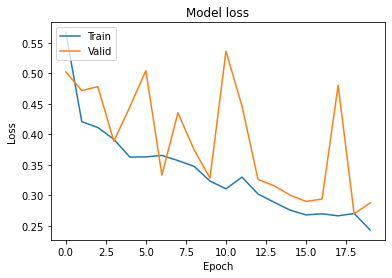

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [18]:
# Saving the model
model.save('model.h5')

Testing Phase

In [19]:
model = load_model('model.h5')

x_test = np.load(os.path.join(os.getcwd(),"Test_Images.npy"))
y_test = np.load(os.path.join(os.getcwd(),"Test_Masks.npy"))

y_test = np.where(y_test > 1, 1, 0)

In [20]:
x_test.shape

(24, 512, 512, 3)

In [21]:
output = []
for test_img in x_test:
  output.append(model.predict(test_img.reshape(1,512,512,3))[0,:,:,:])
output = np.array(output)

# Convert pixel values from float to integer
output = np.where(output > 0.9, 1, 0)
output = output.astype('uint8')

Time to inference the model for a single image: 0.02413447132421709 s
A 30 FPS real-time engine will require  0.03333333333333333 s inference time for a single Image


Dilation Operation on the predicted masks to smooth out the masks

In [22]:
  kernel = np.ones((15,15),np.uint8)
  dilate_opt = []
  for image in output:
    dilate_opt.append(cv2.dilate(image,kernel,iterations = 1))
  dilate_opt = np.array(dilate_opt)
  dilate_opt = np.expand_dims(dilate_opt, axis=-1)

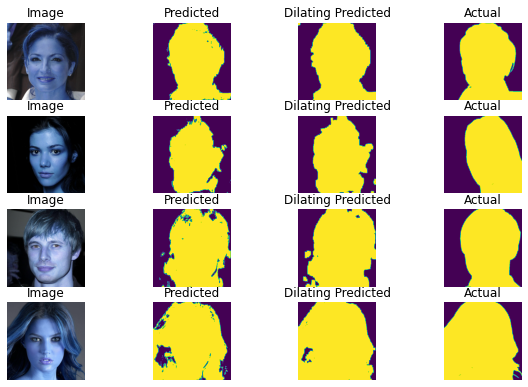

In [23]:
plt.figure(figsize=(10,10))

for i in list(np.linspace(1,13,4, dtype = int)):
  idx = randint(0,24)
  plt.subplot(6,4,i)
  plt.title('Image')
  plt.axis('off')
  plt.imshow(x_test[idx,:,:,:])

  plt.subplot(6,4,i+1)
  plt.title('Predicted')
  plt.axis('off')
  plt.imshow(output[idx,:,:,0])

  plt.subplot(6,4,i+2)
  plt.title('Dilating Predicted')
  plt.axis('off')
  plt.imshow(dilate_opt[idx,:,:,0])

  plt.subplot(6,4,i+3)
  plt.title('Actual')
  plt.axis('off')
  plt.imshow(y_test[idx,:,:,0])

plt.show()